# 1. Problem Statement

> ### This model will aim to predict which tweets are about real disaster and which of them are not using `natural language processing`.

# 2. Imports & Data

## Imports

In [127]:
import os
import re
import string
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nlppreprocess import NLP

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

## Data

### This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ [website](https://www.figure-eight.com/data-for-everyone/) but this dataset is readily avaliable on [Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview).

The Dataset has two csv- one with train data and other with test data. The dataset contains 4 features.
- id: Used for submission
- keyword: Keyword of the tweet
- location: Location the tweet was sent from
- text: The Tweet itself

In [128]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [129]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [130]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 3. EDA

In [131]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [132]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [133]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [134]:
train.isnull().mean()*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [135]:
test.isnull().mean()*100

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

About 33% location data and 0.8% keyword data is missing from the datasets

Viewing Tweets

In [136]:
# Non-disaster tweet
train[train['target']==0]['text'].values[4]

'What a goooooooaaaaaal!!!!!!'

In [137]:
# Disaster Tweet
train[train['target']==1]['text'].values[4]

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

#### Target Features

In [138]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [139]:
is_disaster = train.target.value_counts()[1]
nan_disaster = train.target.value_counts()[0]

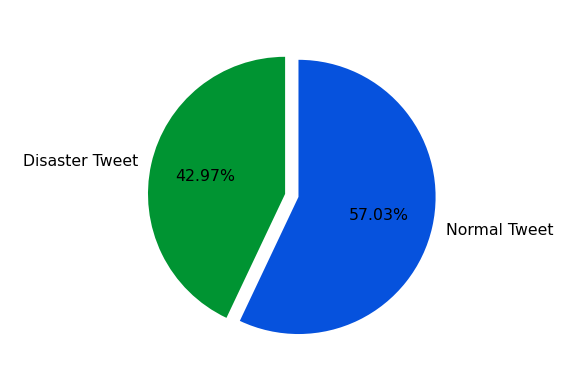

In [140]:
category_names = ['Disaster Tweet', 'Normal Tweet']
sizes = [is_disaster, nan_disaster]
custom_colors = ['#009432', '#0652DD']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 5}, startangle=90,
        autopct='%1.2f%%', colors=custom_colors, explode=[0, 0.1])

plt.show()

In [141]:
target = train['target'].value_counts()
target

0    4342
1    3271
Name: target, dtype: int64

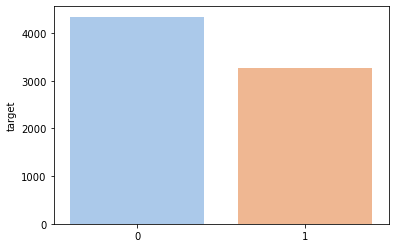

In [142]:

sns.barplot(target.index, target, palette="pastel")

#### Keyword features

In [143]:
keyW = train['keyword']
keyW.nunique()

221

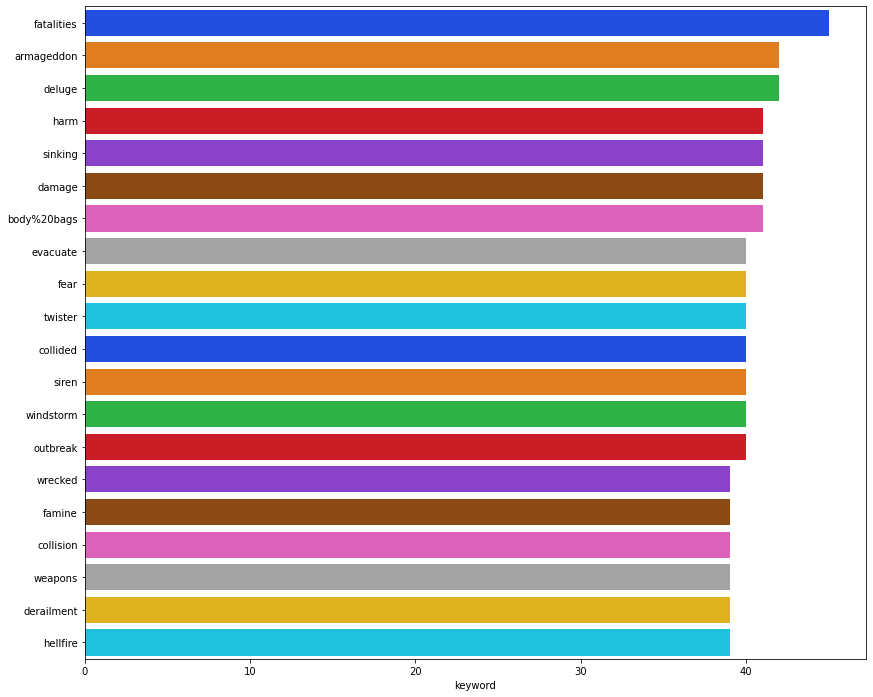

In [144]:
figure = plt.figure(figsize=(14, 12))
sns.barplot(y=keyW.value_counts().index[:20], x=keyW.value_counts()[:20], palette="bright")

#### location feature

In [145]:
locL = train['location']
locL.nunique()

3341

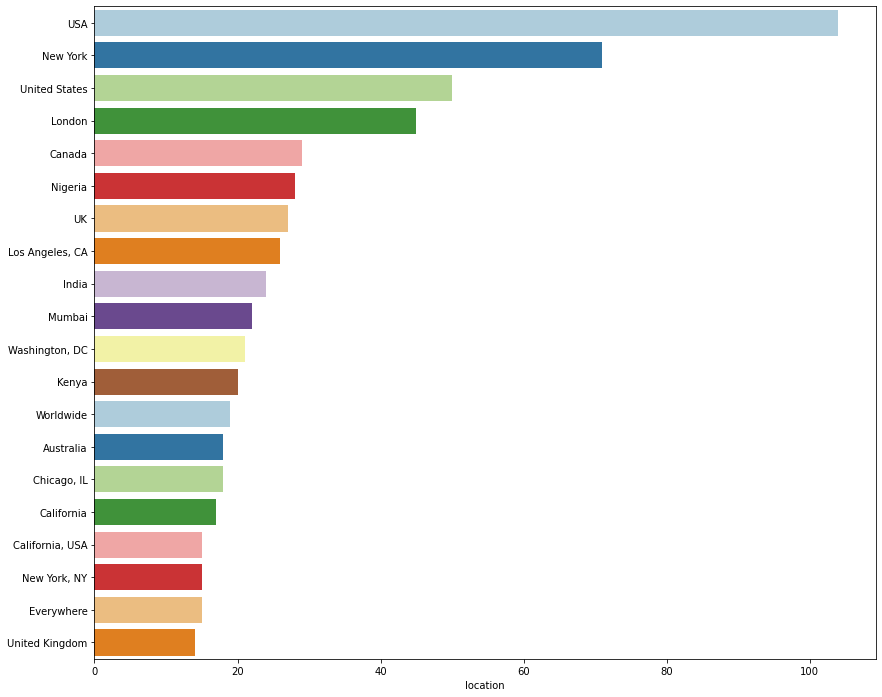

In [146]:
figure = plt.figure(figsize=(14, 12))
sns.barplot(y=locL.value_counts().index[:20], x=locL.value_counts()[:20], palette="Paired")

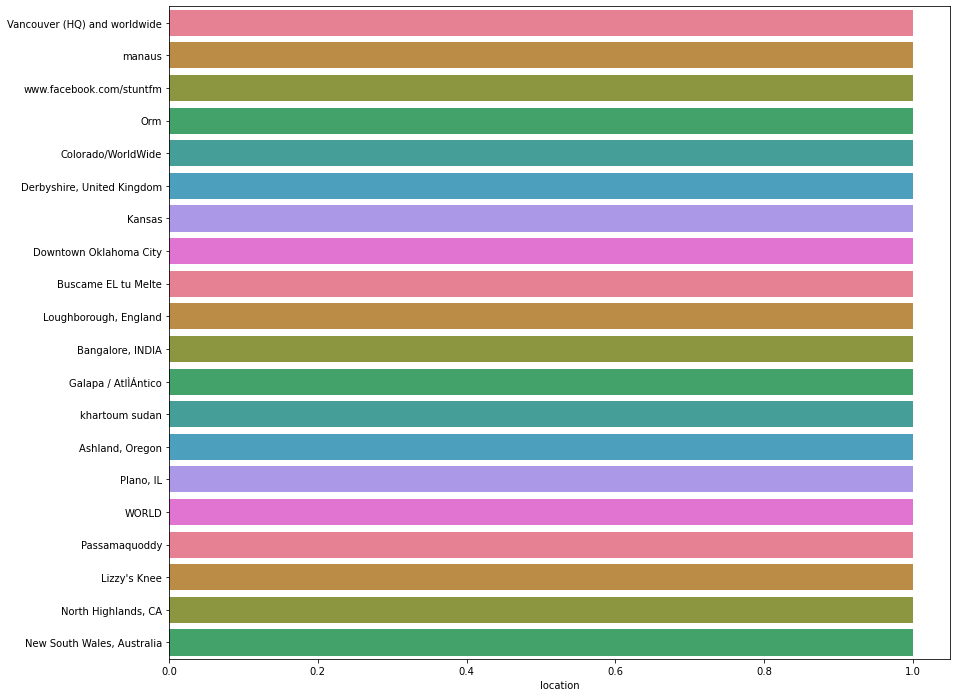

In [147]:
# Least common places
current_palette = sns.color_palette(sns.color_palette("husl", 8))
figure = plt.figure(figsize=(14, 12))
sns.barplot(y=locL.value_counts().index[-20:], x=locL.value_counts()[-20:], palette= current_palette)

# 4. Text Pre-processing

- LowerCase all words
- Stopwords
- Removing noise
- Stemming
- Tokenizing

Removing uppercase and noise

In [148]:
def pre_process(text): 
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [149]:
train['text'] = train['text'].apply(lambda x: pre_process(x))
test['text'] = test['text'].apply(lambda x: pre_process(x))

In [150]:
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Removing Stopwords using `nlp-preprocess` module

In [151]:
train['text'] = train['text'].apply(NLP().process)
test['text'] = test['text'].apply(NLP().process)


In [152]:
train['text'].head()

0    our deeds are reason earthquake may allah forg...
1                forest fire near la ronge sask canada
2    residents asked shelter in place are being not...
3    people receive wildfires evacuation orders in ...
4    just got sent photo from ruby alaska smoke fro...
Name: text, dtype: object

Stemming the words

In [153]:
stemmer = SnowballStemmer("english")

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

train['text'] = train['text'].apply(stemming)
test['text'] = test['text'].apply(stemming)

In [154]:
train['text'].head()

0    our deed are reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter in place are be notifi by of...
3       peopl receiv wildfir evacu order in california
4    just got sent photo from rubi alaska smoke fro...
Name: text, dtype: object

### WordCloud

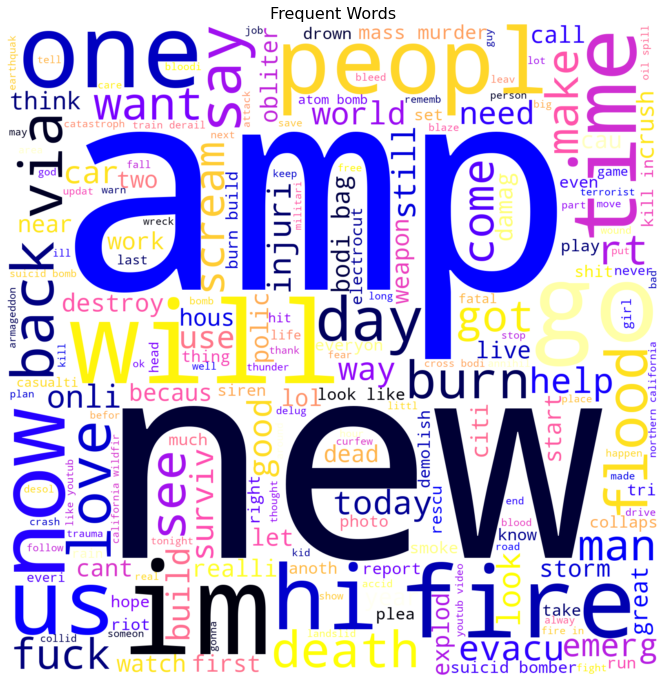

In [155]:
fig, (ax1) = plt.subplots(1, figsize=[12, 12])
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=1600,
                      colormap='gnuplot2').generate(" ".join(train['text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
ax1.set_title('Frequent Words',fontsize=16);

Vectorizing the tweets

In [156]:
# Using CountVectorizer to change the teweets to vectors
count_vectorizer = CountVectorizer(analyzer='word', binary=True)
count_vectorizer.fit(train['text'])

train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

In [157]:
train_vectors.shape

(7613, 13367)

In [158]:
print(train_vectors[0])

  (0, 8505)	1
  (0, 2934)	1
  (0, 573)	1
  (0, 9527)	1
  (0, 3512)	1
  (0, 7239)	1
  (0, 313)	1
  (0, 4350)	1
  (0, 12448)	1


In [159]:
y = train['target']

# 5. Modelling

In [194]:
model = MultinomialNB(alpha=0.8)

scores = model_selection.cross_val_score(model, train_vectors, y, cv=3, scoring="f1")
scores

array([0.67295894, 0.65808666, 0.71566569])

# 6. Training & Tuning Model

In [195]:
X_train, X_valid, y_train, y_valid = train_test_split(train_vectors, y, 
                                                    test_size=0.3, random_state=88)

In [198]:
model.fit(X_train, y_train, sample_weight=0.8)

MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)

### 7 Evaluating model

> #### The evaluation metrics for this competition is the f1 score

In [199]:
nr_correct = (y_valid == model.predict(X_valid)).sum()
print(f'{nr_correct} documents classfied correctly')

nr_incorrect = y_valid.size - nr_correct
print(f'Number of documents incorrectly classified is {nr_incorrect}')

fraction_wrong = nr_incorrect / (nr_correct + nr_incorrect)
print(f'The (testing) accuracy of the model is {1-fraction_wrong:.2%}')

f1 = f1_score(y_valid, model.predict(X_valid))
print(f'The F1 score on the validation data is {f1}')

1824 documents classfied correctly
Number of documents incorrectly classified is 460
The (testing) accuracy of the model is 79.86%
The F1 score on the validation data is 0.7578947368421053


In [ ]:
0.7578947368421053
0.7585123101100052
0.7597301504929943

# 7. Predicting

In [164]:
sub = pd.read_csv("sample_submission.csv")


In [189]:
sub['target'] = model.predict(test_vectors)

In [190]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [167]:
sub.to_csv("submission_tr.csv", index=False)

In [168]:
sub.to_csv("submission_tr1.csv", index=False)

In [191]:
sub.to_csv("submission_tr2.csv", index=False)

In [192]:
sub1 = pd.read_csv("submission_tr.csv")
sub2 = pd.read_csv("submission_tr1.csv")
sub3 = pd.read_csv("submission_tr2.csv")

In [170]:
(sub1['target']==0).value_counts()

True     2050
False    1213
Name: target, dtype: int64

In [171]:
(sub2['target']==0).value_counts()

True     2050
False    1213
Name: target, dtype: int64

In [193]:
(sub3['target']==0).value_counts()

True     1995
False    1268
Name: target, dtype: int64